# **Sentiment Analysis Using Word2Vec, Fasttext and Glove**

### **Dataset**

IMDb Movie Reviews dataset is a binary sentiment analysis dataset consisting of 50,000 reviews.

*   Dataset source : https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

*   This data consists of two columns:

    1.   Review
    2.   Sentiment





In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import os

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

from gensim.models import Word2Vec


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#read the dataset and store it in a variable df
df = pd.read_csv("/content/drive/MyDrive/Text Classification IMDB/IMDB Dataset.csv")

#print the shape of dataframe
print("shape: ",df.shape)

#print top 5 rows
df.head(5)

shape:  (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
#the distribution of labels 

df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
#See if the data contains any missing value

df.isnull().sum()

review       0
sentiment    0
dtype: int64

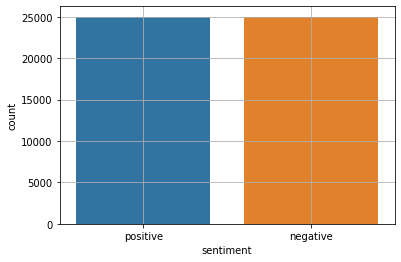

In [ ]:
# Plot each type of sentiment in the dataset using seaborn library

sns.countplot(x=df['sentiment'])
plt.grid()

### **Data Preprocessing**

In [ ]:
#Add the new column which gives a unique number to each of these labels 

df['sentiment_num'] = df['sentiment'].map({'positive' : 1, 'negative': 0})

#check the results with top 5 rows
df.head(5)

,review,sentiment,sentiment_num
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
df = df[:5000]
df.shape

(5000, 3)

**Text Cleaning**

In [ ]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

As we can see , there are couple of HTML tags in the dataset. We will be getting rid of them , white spaces, some special characters, etc.

In [ ]:
def decontracted(review):
  review = str(review).lower()
  x = review.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
  .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
  .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
  .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
  .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
  .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
  .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
  .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
  .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
  .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
  .replace("'cause'"," because")
    
  review = re.sub(r"([0-9]+)000000", r"\1m", x)
  review = re.sub(r"([0-9]+)000", r"\1k", x)
  return review

In [ ]:
# Removing Stopwords
def remove_stopwords(review):
    from nltk.corpus import stopwords
    stopwords = set(stopwords.words('english'))
    remove_not = set(['no', 'nor', 'not'])
    custom_stopwords = stopwords - remove_not
    cleaned_review = [words.lower() for words in review.split() if words not in custom_stopwords]
    return " ".join(cleaned_review)

# Removing Punctuations
def remove_punctuation(review):
    no_punct = [words for words in review if words not in string.punctuation]
    words_wo_punct = ''.join(no_punct)
    return words_wo_punct

# Removing HTML tags
def remove_htmltags(review):
    CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleaned_review = re.sub(CLEANR, '', review)
    return cleaned_review

# Removing URLS
def remove_url(review):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',review)

# Removing Numbers
def remove_numbers(review): 
    cleaned_review = ''.join((x for x in review if not x.isdigit()))
    return cleaned_review

# Apply Stemming
def stemming(review):
    ps = PorterStemmer()
    return " ".join([ps.stem(word) for word in review.split()])

In [ ]:
# Apply all the preprocessing functions
df = df.drop_duplicates()
def clean_data(review):
    return stemming(remove_numbers(remove_url(remove_htmltags(remove_punctuation(remove_stopwords(review))))))

df['review'] = df['review'].apply(lambda review: clean_data(review))

In [ ]:
df['review'][0]

'one review mention watch oz episod hook they right exactli happen mebr br the first thing struck oz brutal unflinch scene violenc set right word go trust me not show faint heart timid thi show pull no punch regard drug sex violenc it hardcor classic use wordbr br it call oz nicknam given oswald maximum secur state penitentari it focus mainli emerald citi experiment section prison cell glass front face inward privaci not high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awaybr br i would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz mess around the first episod i ever saw struck nasti surreal i say i readi it i watch more i develop tast oz got accustom high level graphic violenc not violenc injustic crook guard wholl sold nickel inmat wholl kill order get away it well manner middl class inmat turn prison bitch due lack s

In [ ]:
df['sentiment'].value_counts()

negative    2531
positive    2466
Name: sentiment, dtype: int64

**Convert the reviews to a matrix of token counts**

In [ ]:
cv=CountVectorizer()
X=cv.fit_transform(df['review']).toarray()
y = df['sentiment_num']

In [ ]:
# train-test splitting with test size of 20% with random state of 42 and stratify sampling too
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state=42)

In [ ]:
# creating a Naive Bais model object
nb=MultinomialNB()

# fit with X_train and y_train
nb.fit(X_train,y_train)

#get the predictions for X_test and store it in y_pred
y_pred=nb.predict(X_test)

In [ ]:
#print the score and the classfication report
score=accuracy_score(y_pred,y_test)
print("The score : " ,score)
print(classification_report(y_pred,y_test))

The score :  0.819
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       554
           1       0.77      0.85      0.81       446

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



**Converting every review into tokens**

In [ ]:
review_data_list=[]
lines = df['review'].values.tolist()
for indv_lines in lines :
    review_splited = [word for word in indv_lines.split()]
    review_data_list.append(review_splited)

print("Lenght of the voca : ",len(review_data_list))

Lenght of the voca :  4997


### **Word2Vec Model**

In [ ]:
# creating word2vec model object
wv_model = Word2Vec(sentences=review_data_list,  window=5, min_count=1, workers=3)

# train the model 
wv_model.train(review_data_list, total_examples=wv_model.corpus_count, epochs=wv_model.epochs)

(3104790, 3398450)

In [ ]:
#the embedding vocabulary
list(wv_model.wv.vocab)

In [ ]:
#the embedding vector of film
wv_model.wv['film']

array([ 4.2339730e-01,  6.1863047e-01,  6.4027017e-01, -1.4017882e+00,
        2.9691717e-01,  9.1145402e-01, -3.9364475e-01, -1.3491915e+00,
        9.4539297e-01,  3.5574937e-01,  7.7793097e-01,  1.2042928e+00,
        5.8174711e-01,  3.6972034e-01, -6.5363723e-01, -3.1098183e-02,
       -6.6690095e-02,  8.5327494e-01, -1.7174762e-01,  7.5384147e-02,
        8.4357703e-04, -9.7697711e-01, -3.5241663e-01,  4.7021382e-02,
       -1.9483932e+00,  1.7227162e+00,  6.9985235e-01, -1.9375689e+00,
        8.5898513e-01, -5.4185066e-02, -3.2766119e-01,  7.6604891e-01,
       -1.2930105e+00, -7.1633190e-02, -3.0197036e-02,  2.8868222e-01,
       -3.3653381e-01,  8.1083220e-01, -1.7730672e+00,  6.1295485e-01,
        8.1407970e-01, -1.2527536e-01, -6.5974808e-01,  1.3811086e-01,
       -2.5401679e-01, -6.6184437e-01, -1.1289045e+00,  5.5092871e-01,
        4.2230383e-01,  1.8653252e+00,  1.4267690e+00, -1.3883413e+00,
       -9.5709372e-01,  1.8560598e+00,  8.1644106e-01, -5.5298559e-02,
      

In [ ]:
# 5 relatable words in the vocabulary to the word film.
wv_model.wv.most_similar("film",topn=5)

[('movi', 0.867219090461731),
 ('documentari', 0.7973163723945618),
 ('pictur', 0.7181060910224915),
 ('cinema', 0.7180973887443542),
 ('product', 0.7116018533706665)]

In [ ]:
#the similarity score
wv_model.wv.similarity("movi","film")

0.86721903

In [ ]:
# docmean = [[embedding of each review]] 
docmean = []
for review in review_data_list:
  list_of_word_embed = []
  # for word in each review from the review_data_list
  for word in review:
    try:
      #Append the embedding of the word to the list_of_word_embed variable
      list_of_word_embed.append(wv_model.wv[word])
    except:
      #Append a list of zeros 
      list_of_word_embed.append(np.zeros((100,)))
  # the mean of the embedding of all word in each review
  embedded_review = np.mean(list_of_word_embed,axis=0) 
  docmean.append(embedded_review)
docmean = np.array(docmean)

In [ ]:
# train-test splitting with test size of 20% with random state of 42 and stratify sampling too
X_train_wv, X_test_wv, y_train_wv, y_test_wv = train_test_split(docmean, y, test_size = 0.20, stratify=y, random_state=42)

In [ ]:
from sklearn import tree
# creating a Decision Tree model object
clf = tree.DecisionTreeClassifier()

# fit with X_train_wv and y_train_wv
clf = clf.fit(X_train_wv,y_train_wv)

#get the predictions for X_test_wv and store it in dt_pred
dt_pred = clf.predict(X_test_wv)

#print the score and the classfication report
score=accuracy_score(dt_pred,y_test_wv)
print("Decision Tree score : " ,score)
print(classification_report(y_test_wv,dt_pred))

Decision Tree score :  0.66
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       507
           1       0.66      0.64      0.65       493

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000



In [ ]:
from sklearn.ensemble import RandomForestClassifier
# creating a Random Forest model object
forest = RandomForestClassifier(n_estimators = 100)

# fit with X_train_wv and y_train_wv
forest = forest.fit(X_train_wv, y_train_wv)

#get the predictions for X_test_wv and store it in rf_pred
rf_pred = forest.predict(X_test_wv)

#print the score and the classfication report
score=accuracy_score(rf_pred,y_test_wv)
print("Random Forest score : " ,score)
print(classification_report(y_test_wv,rf_pred))

Random Forest score :  0.764
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       507
           1       0.76      0.76      0.76       493

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



In [ ]:
from sklearn.linear_model import LogisticRegression
# creating a Logistic Regression model object
lr = LogisticRegression()

# fit with X_train_wv and y_train_wv
lr = lr.fit(X_train_wv, y_train_wv)

#get the predictions for X_test_wv and store it in rf_pred
lr_pred = lr.predict(X_test_wv)

#print the score and the classfication report
score=accuracy_score(lr_pred,y_test_wv)
print("Logistic Regression score : " ,score)
print(classification_report(y_test_wv,lr_pred))

Logistic Regression score :  0.812
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       507
           1       0.82      0.80      0.81       493

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### **FastTest Model**

In [ ]:
#first install fasttext
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 2.9 MB/s 
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=3133786 sha256=872d6315bd6492e9e9de9dfb9f8640ab00267a4cd6bd0e1c60de458d27b45a51
  Stored in directory: /root/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext


In [ ]:
df.head()

,review,sentiment,sentiment_num
0,one review mention watch oz episod hook they r...,positive,1
1,a wonder littl product br br the film techniqu...,positive,1
2,i thought wonder way spend time hot summer wee...,positive,1
3,basic there famili littl boy jake think there ...,negative,0
4,petter mattei love time money visual stun film...,positive,1


In [ ]:
df["sentiment_ft"] = ['__label__'+str(i) for i in df["sentiment_num"].values]

In [ ]:
df.head()

,review,sentiment,sentiment_num,sentiment_ft
0,one review mention watch oz episod hook they r...,positive,1,__label__1
1,a wonder littl product br br the film techniqu...,positive,1,__label__1
2,i thought wonder way spend time hot summer wee...,positive,1,__label__1
3,basic there famili littl boy jake think there ...,negative,0,__label__0
4,petter mattei love time money visual stun film...,positive,1,__label__1


When you train a fasttext model, it expects labels to be specified with **__ label __** prefix.\
We will just create a new column in the dataframe **review_labled**

In [ ]:
df['review_labled'] = df['sentiment_ft'] + ' ' + df['review']
df.head(2)

,review,sentiment,sentiment_num,sentiment_ft,review_labled
0,one review mention watch oz episod hook they r...,positive,1,__label__1,__label__1 one review mention watch oz episod ...
1,a wonder littl product br br the film techniqu...,positive,1,__label__1,__label__1 a wonder littl product br br the fi...


In [ ]:
ft_train, ft_test  = train_test_split(df, test_size = 0.20,random_state=42)
print("fattext train shape :",ft_train.shape)
print("fattext test shape :",ft_test.shape)

fattext train shape : (3997, 5)
fattext test shape : (1000, 5)


In [ ]:
ft_train.to_csv("ft_data.train", columns=["review_labled"], index=False, header=False)
ft_test.to_csv("ft_data.test", columns=["review_labled"], index=False, header=False)

In [ ]:
import fasttext

ft_model = fasttext.train_supervised(input="ft_data.train")
ft_model.test("ft_data.test")

(1000, 0.695, 0.695)

In [ ]:
ft_model.get_nearest_neighbors("great")

[(0.9953746199607849, 'salti'),
 (0.9953280687332153, 'vera'),
 (0.9953134655952454, 'newer'),
 (0.9952556490898132, 'cedric'),
 (0.9952457547187805, 'cb'),
 (0.9952169060707092, 'geographi'),
 (0.9952124953269958, 'harvey'),
 (0.9952048659324646, 'endlessli'),
 (0.9951822757720947, 'cutaway'),
 (0.9951820969581604, 'ole')]

In [ ]:
ft_model.predict("good")

(('__label__1',), array([0.55128968]))

In [ ]:
ft_model.predict("bad", k=2)

(('__label__0', '__label__1'), array([0.70230591, 0.29771411]))

In [ ]:
# Trai  fasttext unsupervised

In [ ]:
reviews_labled = df[['review_labled']].values

In [ ]:
with open('review.txt', 'w') as f:
    for line in reviews_labled:
        f.write(str(line))
        f.write('\n')

In [ ]:
ft_model_unsup = fasttext.train_unsupervised(input="review.txt")

In [ ]:
ft_model_unsup.get_nearest_neighbors("great")

[(0.9020617604255676, 'greatli'),
 (0.8601268529891968, 'greatbr'),
 (0.8402081727981567, 'fantast'),
 (0.8398013114929199, 'greatest'),
 (0.8205097317695618, 'catchi'),
 (0.8200657367706299, 'greater'),
 (0.810566246509552, 'grit'),
 (0.810384213924408, 'amaz'),
 (0.810027003288269, 'alway'),
 (0.8066152930259705, 'brownrigg')]